# CAPM Data Project

In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

#from dataproject import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Data

## 1.1 Importing data

In [61]:
# Importing monthly data from Yahoo Finance
data = yf.download(["MSFT", "NVO", "TSLA"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
data = data['Adj Close'] # Only look at the adjusted close

# Calculate monthly returns
data["MSFT_returns"] = data["MSFT"].pct_change() * 100
data["NVO_returns"] = data["NVO"].pct_change() * 100
data["TSLA_returns"] = data["TSLA"].pct_change() * 100
data = data.dropna()

print(data.shape)

[*********************100%%**********************]  3 of 3 completed

(52, 6)


## 1.2 Merging with Fama-French

In [62]:
# Load Data with market return and risk free return
df = pd.read_excel('Fama-French.xlsx')
df.columns = ['Date'] + list(df.columns[1:]) # Change name of first column
df.set_index("Date", inplace=True) # Set the date column as the index
print(df.head())

        Mkt-RF    RF
Date                
192607    2.96  0.22
192608    2.64  0.25
192609    0.36  0.23
192610   -3.24  0.32
192611    2.53  0.31


In [63]:
# Change the format of the index to date time
df.index = pd.to_datetime(df.index, format='%Y%m')

# Create dataframe with returns
return_df = data.iloc[:, 3:] 

# Merge the dataframes on the dates
merged_data = return_df.merge(df, left_index=True, right_index=True, how='inner')

# Print the first few rows of the merged dataframe to verify
print(merged_data.head())

            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF
Date                                                             
2020-01-01      7.945455     5.096762     55.515986   -0.11  0.13
2020-02-01     -4.828741    -4.438606      2.677647   -8.13  0.12
2020-03-01     -2.388262     3.560987    -21.555707  -13.39  0.13
2020-04-01     13.632620     5.199333     49.213732   13.65  0.00
2020-05-01      2.254332     4.121285      6.793887    5.58  0.01


In [64]:
# Loop over the columns to create new column with the stock return minus the risk free return
for column in return_df.columns:
    merged_data[column + '-RF'] = merged_data[column] - merged_data['RF']

print(merged_data.head())


            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF  \
Date                                                                
2020-01-01      7.945455     5.096762     55.515986   -0.11  0.13   
2020-02-01     -4.828741    -4.438606      2.677647   -8.13  0.12   
2020-03-01     -2.388262     3.560987    -21.555707  -13.39  0.13   
2020-04-01     13.632620     5.199333     49.213732   13.65  0.00   
2020-05-01      2.254332     4.121285      6.793887    5.58  0.01   

            MSFT_returns-RF  NVO_returns-RF  TSLA_returns-RF  
Date                                                          
2020-01-01         7.815455        4.966762        55.385986  
2020-02-01        -4.948741       -4.558606         2.557647  
2020-03-01        -2.518262        3.430987       -21.685707  
2020-04-01        13.632620        5.199333        49.213732  
2020-05-01         2.244332        4.111285         6.783887  


# 2 Regression

In [65]:
import statsmodels.api as sm

# Prepare the explanatory variable (Excess market returns), adding a constant for the intercept
X = sm.add_constant(merged_data['Mkt-RF'])

# Loop through each stock return column and perform regression
results = {}
for return_col in merged_data.iloc[:, 5:]:
    # Prepare the dependent variable
    y = merged_data[return_col]  # Dependent variable (stock excess returns)

    # Fit the regression model
    model = sm.OLS(y, X, missing='drop')  # OLS regression, excluding NaN values
    results[return_col] = model.fit()

    # Print the summary of the regression results
    #print(f"Regression Results for {return_col}:\n")
    #print(results[return_col].summary())
    #print("\n\n")


In [66]:
def beta_table(results):
    # List to save beta values
    beta_values = {}

    for key, result in results.items():
        beta_values[key] = round(result.params['Mkt-RF'], 3)

    # Extract constant values
    constant_values = {}

    for key, result in results.items():
        constant_values[key] = round(result.params['const'], 3)

    # Calculate t-values for the 'Mkt-RF' coefficient
    t_values = {}
    for key, result in results.items():
        t_values[key] = round(result.params['Mkt-RF'] / result.bse['Mkt-RF'], 2)
    # Calculate t-values for the constant coefficient

    t_values_a = {}
    for key, result in results.items():
        t_values_a[key] = round(result.params['const'] / result.bse['const'], 2)    

    beta_table = pd.DataFrame(list(beta_values.items()), columns=['Stock', 'Beta'])

    # Add constant values and t-values to the DataFrame
    beta_table['t_Beta'] = t_values.values()
    beta_table['cons'] = constant_values.values()
    beta_table['t_cons'] = t_values_a.values()

    return beta_table


In [67]:
print(beta_table(results))

             Stock   Beta  t_Beta   cons  t_cons
0  MSFT_returns-RF  0.816    7.04  1.246    1.84
1   NVO_returns-RF  0.350    2.48  2.659    3.23
2  TSLA_returns-RF  2.471    5.38  3.706    1.38


# 3 Portfolios

## 3.1 Return and covariance matrix

In [68]:
# Keep returns of Novo, Microsoft and Tesla
returns = data.iloc[:,3:]

# Calculate the average return over the period
return_matrix = np.mean(returns, axis = 0)
print(return_matrix)

Ticker
MSFT_returns    2.190104
NVO_returns     3.142030
TSLA_returns    5.845781
dtype: float64


In [69]:
# Calculate covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)
print("\n")

# Prints standard deviations
volatility_matrix = np.sqrt(np.var(returns, axis=0, ddof=1))
print(volatility_matrix)

Ticker        MSFT_returns  NVO_returns  TSLA_returns
Ticker                                               
MSFT_returns     42.549153    20.273103     83.367904
NVO_returns      20.273103    36.103364     -1.203836
TSLA_returns     83.367904    -1.203836    531.660423


Ticker
MSFT_returns     6.522971
NVO_returns      6.008608
TSLA_returns    23.057763
dtype: float64


## 3.2 Minimum Variance Portfolio

In [70]:
# Define portfolio function, which returns ER and Volatility for any portfolio weights W
def portfolio(w1, w2, return_matrix=return_matrix, cov_matrix=cov_matrix):
    index = return_matrix.index # Get index of return matrix
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=index) # Set weights to have matching index with returns
    tW = W.transpose() # Transposed weight matrix

    var = tW.dot(cov_matrix).dot(W) # Formula for calculating variance
    sd = np.sqrt(var)[0][0]

    e_r = tW.dot(return_matrix)[0]

    return e_r, sd

In [71]:
er, sd = portfolio(0, 0)

print(f'Expected return = {er:.3f}, Volatility (standard deviation) = {sd:.3f}')

Expected return = 5.846, Volatility (standard deviation) = 23.058


In [72]:
def mvp_w(N, portfolio = portfolio):
    N = N
    w1_vec = np.linspace(0, 1.25, N)
    w2_vec = np.linspace(0, 1.25, N)
    vol_best = np.inf
    w1_best = 0
    w2_best = 0
    for w1 in w1_vec:
        for w2 in w2_vec: 
            vol = portfolio(w1, w2)[1]
            if vol < vol_best:
                vol_best = vol
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

w1_min, w2_min = mvp_w(100)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')


Minimum variance weights: w1 = 0.442, w2 = 0.568, w3 = -0.010


In [73]:
mvp = portfolio(w1_min, w2_min)
print(f'MVP return = {mvp[0]:.3f}, MVP volatility = {mvp[1]:.3f}')

MVP return = 2.694, MVP volatility = 5.429


In [74]:
def plot_variance(portfolio=portfolio, delta = 0.5):
    # Generate weight values
    w_values = np.linspace(-1, 1.25, 100)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Empty volatility values
    volatility_values = []
    volatility_values2 = []
    volatility_values3 = []

    delta = delta

    for w in w_values:
        # Calculate the function values
        volatility_values.append(portfolio(w, w2_min)[1])
        volatility_values2.append(portfolio(w, w2_min - delta)[1])
        volatility_values3.append(portfolio(w, w2_min + delta)[1])

    # Plot functions value and optimum
    ax.plot(w_values, volatility_values, label = "volatility")
    ax.scatter(w1_min, mvp[1], c = "red", label = "minimum variance portfolio")

    ax.plot(w_values, volatility_values2)
    ax.plot(w_values, volatility_values3)


    # Add labels and a legend
    ax.set_xlabel('weight')
    ax.set_ylabel('Standard deviation')
    ax.legend()

    ax.set_xlim(-0.5, 1.25)
    ax.set_ylim(4.5, 8)
    plt.show()

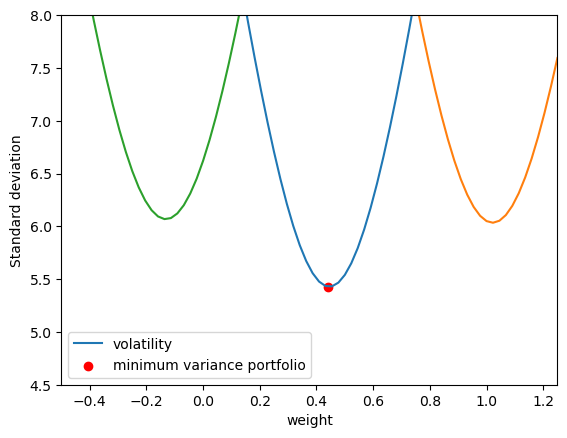

In [75]:
plot_variance()

## 3.2 Efficient Tangent Portfolio

In [76]:
def sharpe_ratio(w1, w2, portfolio=portfolio, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(w1, w2) # Expected return and volatility

    sharpe = (e_r - rf)/sd
    return sharpe

In [77]:
rf_mean = np.mean(df["RF"])

In [78]:
def etp_w(N):
    '''Calculates Efficient Tangent Portfolio by finding the highest Sharpe ratio'''

    # Create linear weight vector
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)

    # Initial best volatility and weight
    sharpe_best = -np.inf
    w1_best = 0
    w2_best = 0

    # Loops over all weight and saves the weight if the volatility is lower than before
    for w1 in w1_vec:
        for w2 in w2_vec:
            sharpe = sharpe_ratio(w1, w2)
            if sharpe > sharpe_best:
                sharpe_best = sharpe
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

In [79]:
w1_etp, w2_etp = etp_w(100)
print(f'Efficient tangent portfolio weights: w1 = {w1_etp:.3f}, w2 = {w2_etp:.3f} and w3 = {1-w1_etp-w2_etp:.3f}\n')

Efficient tangent portfolio weights: w1 = -0.333, w2 = 1.152 and w3 = 0.182



In [80]:
etp = portfolio(w1_etp, w2_etp)
print(f'ETP return = {etp[0]:.3f}, ETP volatility = {etp[1]:.3f}')

ETP return = 3.951, ETP volatility = 6.634


In [81]:
def plot_sharp(delta=0.5):
    '''Plots Sharpe ratios and the efficient tangent portfolio'''

    # Generate the values for x, y, and z
    w1_values = np.linspace(-1.5, 1, 100)  # Varying values for the third input

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the values of the function for each w value
    function_values = []
    function_values2 = []
    function_values3 = []

    delta = delta

    for w1 in w1_values:
        function_values.append(sharpe_ratio(w1, w2_etp))
        function_values2.append(sharpe_ratio(w1, w2_etp - delta)) 
        function_values3.append(sharpe_ratio(w1, w2_etp + delta))  

    ax.plot(w1_values, function_values, label = "sharpe ratio")
    ax.plot(w1_values, function_values2)
    ax.plot(w1_values, function_values3)
    ax.scatter(w1_etp, sharpe_ratio(w1_etp, w2_etp), c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('weight')
    ax.set_ylabel('Sharpe ratio')
    ax.legend()

    ax.set_xlim(-1.5, 1)
    ax.set_ylim(0.2, .65)
    plt.show()

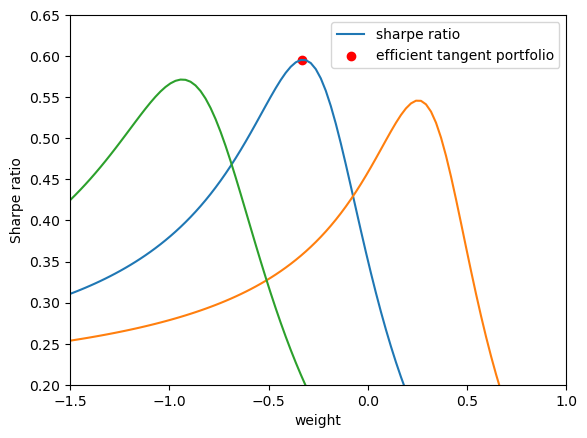

In [82]:
plot_sharp()

## 2.3 Efficient market frontier

In [83]:
# Weights for the MVP and ETP
mvp_weights = pd.DataFrame([w1_min, w2_min, 1 - w1_min - w2_min])
etp_weights = pd.DataFrame([w1_etp, w2_etp, 1 - w1_etp - w2_etp])

# Creating y_vec and lin_vec to store linear combinations
y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0:2])

In [84]:
def plot_capm(mvp, etp, lin_vec, portfolio=portfolio):
    '''Plots the efficient frontier and the capital market line'''
    fig, ax = plt.subplots()

    # Empty vector to store frontier
    frontier = []

    for l in lin_vec:
        # Calculate the function values
        frontier.append(portfolio(l[0], l[1])) 
        
    return_values, vol_values = zip(*frontier)

    rf = 0
    point_rf = [0, rf]
    point_etp = [etp[1], etp[0]]

    # Compute the equation of the line passing through the two points
    # y = mx + c, where m is the slope and c is the y-intercept
    slope = (point_etp[1] - point_rf[1]) / (point_etp[0] - point_rf[0])
    y_intercept = point_rf[1] - slope * point_rf[0]

    # Generate x values for the line
    x_values = np.linspace(0, 10, 100)
    # Compute corresponding y values
    y_values = slope * x_values + y_intercept

    # Plot the capital market line i.e. tangent line
    plt.plot(x_values, y_values, label='Capital market line', linewidth = 0.5, color = "black")

    # Plot Efficient frontier and different portfolios and stocks
    ax.plot(vol_values, return_values, label = "efficient frontier", linewidth = 0.5, color = "blue")
    ax.scatter(mvp[1], mvp[0], c = "green", label = "minimum variance portfolio")
    ax.scatter(etp[1], etp[0], c = "red", label = "efficient tangent portfolio")

    # Plot stocks
    # Generate random colors for each point

    volatility_values = volatility_matrix.values
    return_values = return_matrix.values
    
    ax.scatter(volatility_values, return_values, c = ["purple", "blue", "black"])

    for i, txt in enumerate(data.columns[0:3]):
        ax.annotate(txt, (volatility_values[i], return_values[i]), xytext=(5, 5), textcoords='offset points')

    # Add labels and a legend
    ax.set_xlabel('volatility')
    ax.set_ylabel('return')
    ax.legend()

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    plt.show()

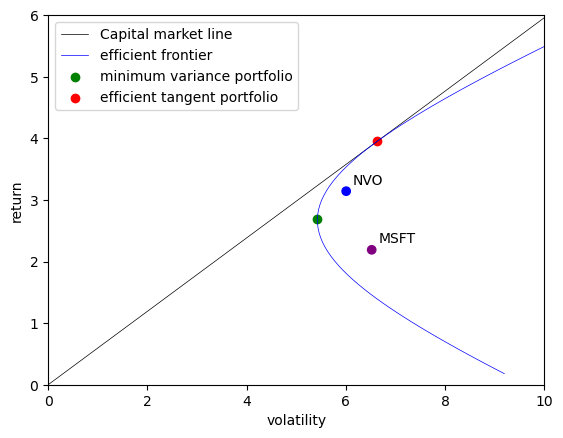

In [85]:
plot_capm(mvp, etp, lin_vec)